# E2B

- https://github.com/e2b-dev/e2b-cookbook/blob/main/examples/gpt-4o-code-interpreter/gpt_4o.ipynb
- https://github.com/e2b-dev/e2b-cookbook/blob/main/examples/o1-code-interpreter-python/o1.ipynb

In [1]:
import openai, json
from e2b_code_interpreter import Sandbox
from dotenv import load_dotenv
load_dotenv()

True

## Sandbox

In [74]:
sbx = Sandbox() # By default the sandbox is alive for 5 minutes
execution = sbx.run_code("print('hello world')") # Execute Python inside the sandbox
print(execution.logs)

Logs(stdout: ['hello world\n'], stderr: [])


In [78]:
sbx.run_code("def fibonacci(n):\n    if n <= 0:\n        return 0\n    elif n == 1:\n        return 1\n    else:\n        a, b = 0, 1\n        for _ in range(2, n + 1):\n            a, b = b, a + b\n        return b\n\n# Get the 10th element\nfibonacci(10)")

Execution(Results: [Result(55)], Logs: Logs(stdout: [], stderr: []), Error: None)

In [80]:
sbx.run_code("fibonacci(42)")


Execution(Results: [Result(267914296)], Logs: Logs(stdout: [], stderr: []), Error: None)

In [4]:
files = sbx.files.list("/")
print(files)

[EntryInfo(name='.dockerenv', type=<FileType.FILE: 'file'>, path='/.dockerenv'), EntryInfo(name='.e2b', type=<FileType.FILE: 'file'>, path='/.e2b'), EntryInfo(name='bin', type=<FileType.FILE: 'file'>, path='/bin'), EntryInfo(name='boot', type=<FileType.DIR: 'dir'>, path='/boot'), EntryInfo(name='code', type=<FileType.DIR: 'dir'>, path='/code'), EntryInfo(name='dev', type=<FileType.DIR: 'dir'>, path='/dev'), EntryInfo(name='etc', type=<FileType.DIR: 'dir'>, path='/etc'), EntryInfo(name='home', type=<FileType.DIR: 'dir'>, path='/home'), EntryInfo(name='ijava-1.3.0.zip', type=<FileType.FILE: 'file'>, path='/ijava-1.3.0.zip'), EntryInfo(name='install.py', type=<FileType.FILE: 'file'>, path='/install.py'), EntryInfo(name='java', type=<FileType.DIR: 'dir'>, path='/java'), EntryInfo(name='lib', type=<FileType.FILE: 'file'>, path='/lib'), EntryInfo(name='lib64', type=<FileType.FILE: 'file'>, path='/lib64'), EntryInfo(name='lost+found', type=<FileType.DIR: 'dir'>, path='/lost+found'), EntryInfo

In [17]:
files[0].type


<FileType.FILE: 'file'>

In [20]:
for file in files:
    print(file.path)

/.dockerenv
/.e2b
/bin
/boot
/code
/dev
/etc
/home
/ijava-1.3.0.zip
/install.py
/java
/lib
/lib64
/lost+found
/media
/mnt
/opt
/proc
/requirements.txt
/root
/run
/sbin
/srv
/swap
/sys
/tmp
/usr
/var


## Connect LLMs to E2B

In [22]:
system = "You are a helpful assistant that can execute python code in a Jupyter notebook. Only respond with the code to be executed and nothing else. Strip backticks in code blocks."
prompt = "Calculate how many r's are in the word 'strawberry'"

# Send messages to OpenAI API
response = openai.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": system},
        {"role": "user", "content": prompt}
    ]
)

# Extract the code from the response
code = response.choices[0].message.content
print(code)

# Execute code in E2B Sandbox
if code:
    with Sandbox() as sandbox:
        execution = sandbox.run_code(code)
        result = execution.text

    print(result)

word = 'strawberry'
count_r = word.count('r')
count_r
3


function calling

In [8]:
model = "gpt-4o"
# prompt = "Calculate how many r's are in the word 'strawberry'"
prompt = "Calculate the 10th element of the Fibonacci sequence."

# Define the messages
messages = [
    {
        "role": "user",
        "content": prompt
    }
]

# Define the tools
tools = [{
    "type": "function",
    "function": {
        "name": "execute_python",
        "description": "Execute python code in a Jupyter notebook cell and return result",
        "parameters": {
            "type": "object",
            "properties": {
                "code": {
                    "type": "string",
                    "description": "The python code to execute in a single cell"
                }
            },
            "required": ["code"]
        }
    }
}]

# Generate text with OpenAI
response = openai.chat.completions.create(
    model=model,
    messages=messages,
    tools=tools,
)

# Append the response message to the messages list
response_message = response.choices[0].message
messages.append(response_message)

# Execute the tool if it's called by the model
if response_message.tool_calls:
    for tool_call in response_message.tool_calls:
        if tool_call.function.name == "execute_python":
            # Create a sandbox and execute the code
            with Sandbox() as sandbox:
                code = json.loads(tool_call.function.arguments)['code']
                execution = sandbox.run_code(code)
                result = execution.text

            # Send the result back to the model
            messages.append({
                "role": "tool",
                "name": "execute_python",
                "content": result,
                "tool_call_id": tool_call.id,
            })

# Generate the final response
final_response = openai.chat.completions.create(
    model=model,
    messages=messages
)
messages.append(final_response.choices[0].message)
print(final_response.choices[0].message.content)

The 10th element of the Fibonacci sequence is 55.


In [9]:
messages

[{'role': 'user',
  'content': 'Calculate the 10th element of the Fibonacci sequence.'},
 ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_rouvGPjX3kuUcQEwgagHFE7B', function=Function(arguments='{"code":"def fibonacci(n):\\n    if n <= 0:\\n        return 0\\n    elif n == 1:\\n        return 1\\n    else:\\n        a, b = 0, 1\\n        for _ in range(2, n + 1):\\n            a, b = b, a + b\\n        return b\\n\\n# Calculate the 10th element\\nfibonacci(10)"}', name='execute_python'), type='function')]),
 {'role': 'tool',
  'name': 'execute_python',
  'content': '55',
  'tool_call_id': 'call_rouvGPjX3kuUcQEwgagHFE7B'},
 ChatCompletionMessage(content='The 10th element of the Fibonacci sequence is 55.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None)]

chaining

In [10]:
messages.append({'role': 'user','content': '42nd element'})
followup_response = openai.chat.completions.create(
    model=model,
    messages=messages,
    tools=tools,
)
followup_response_message = followup_response.choices[0].message
messages.append(followup_response_message)

# Execute the tool if it's called by the model
if followup_response_message.tool_calls:
    for tool_call in followup_response_message.tool_calls:
        if tool_call.function.name == "execute_python":
            # Create a sandbox and execute the code
            with Sandbox() as sandbox:
                code = json.loads(tool_call.function.arguments)['code']
                execution = sandbox.run_code(code)
                result = execution.text

            # Send the result back to the model
            messages.append({
                "role": "tool",
                "name": "execute_python",
                "content": result,
                "tool_call_id": tool_call.id,
            })
print(messages)
# Generate the final response
final_final_response = openai.chat.completions.create(
    model=model,
    messages=messages
)
messages.append(final_final_response.choices[0].message)
print(final_final_response.choices[0].message.content)

[{'role': 'user', 'content': 'Calculate the 10th element of the Fibonacci sequence.'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_rouvGPjX3kuUcQEwgagHFE7B', function=Function(arguments='{"code":"def fibonacci(n):\\n    if n <= 0:\\n        return 0\\n    elif n == 1:\\n        return 1\\n    else:\\n        a, b = 0, 1\\n        for _ in range(2, n + 1):\\n            a, b = b, a + b\\n        return b\\n\\n# Calculate the 10th element\\nfibonacci(10)"}', name='execute_python'), type='function')]), {'role': 'tool', 'name': 'execute_python', 'content': '55', 'tool_call_id': 'call_rouvGPjX3kuUcQEwgagHFE7B'}, ChatCompletionMessage(content='The 10th element of the Fibonacci sequence is 55.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None), {'role': 'user', 'content': '42nd element'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', 

BadRequestError: Error code: 400 - {'error': {'message': "Invalid value for 'content': expected a string, got null.", 'type': 'invalid_request_error', 'param': 'messages.[6].content', 'code': None}}

In [11]:
# Investigate sandbox state
result = sbx.run_code('fibonacci(42)')
result


NameError: name 'sbx' is not defined

## Plot

In [67]:
SYSTEM_PROMPT = """
## your job & context
you are a python data scientist. you are given tasks to complete and you run python code to solve them.
You DO NOT MAKE SYNTAX MISTAKES OR FORGET ANY IMPORTS
- the python code runs in jupyter notebook.
- every time you call `execute_python` tool, the python code is executed in a separate cell. it's okay to multiple calls to `execute_python`.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you have access to the internet and can make api requests.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
- you can run any python code you want, everything is running in a secure sandbox environment.
"""

tools = [
    {
        "type": "function",
        "function": {
          "name": "execute_python",
          "description": "Execute python code in a Jupyter notebook cell and returns any result, stdout, stderr, display_data, and error.",
          "parameters": {
              "type": "object",
              "properties": {
                  "code": {
                      "type": "string",
                      "description": "The python code to execute in a single cell."
                  }
              },
              "required": ["code"]
          }
        },
    }
]

user_message = "Plot a chart visualizing the temperature distribution in Boston over the month of november based on the data you know"
messages = [
    {"role": "system", "content": SYSTEM_PROMPT},
    {"role": "user", "content": user_message}
]

# Generate text with OpenAI
response = openai.chat.completions.create(
    model=model,
    messages=messages,
    tools=tools,
)

# Append the response message to the messages list
response_message = response.choices[0].message
# messages.append(response_message)

# Execute the tool if it's called by the model
if response_message.tool_calls:
    for tool_call in response_message.tool_calls:
        if tool_call.function.name == "execute_python":
            # Create a sandbox and execute the code
            with Sandbox() as sandbox:
                code = json.loads(tool_call.function.arguments)['code']
                execution = sandbox.run_code(code)

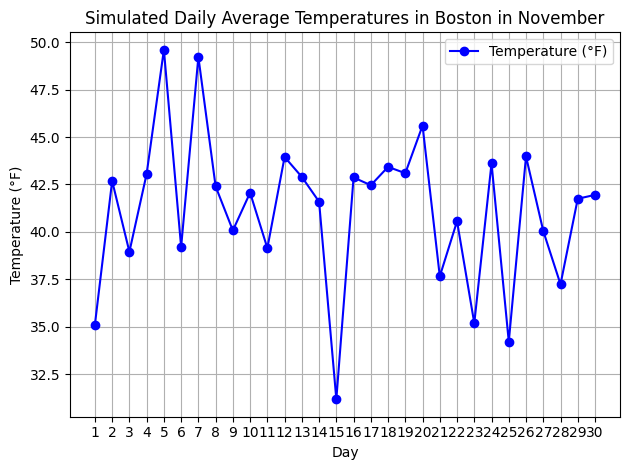

In [71]:
execution.results[0]

In [72]:
print(code)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulate daily average temperatures for Boston in November
days = np.arange(1, 31)
# Typical historical temperature ranges for Boston in November: Low around 35°F, High around 50°F
avgs = np.random.normal(loc=42.5, scale=5.0, size=30)

# Create a DataFrame
df_boston_november = pd.DataFrame({'Day': days, 'Temperature (°F)': avgs})

# Plot the temperature distribution
df_boston_november.plot(x='Day', y='Temperature (°F)', linestyle='-', marker='o', color='b')
plt.title('Simulated Daily Average Temperatures in Boston in November')
plt.xlabel('Day')
plt.ylabel('Temperature (°F)')
plt.grid(True)
plt.xticks(days)
plt.tight_layout()
plt.show()


## Upload file

In [32]:
import requests
import json

# Set up the API endpoint with the sample call
url = "https://samples.openweathermap.org/data/2.5/weather?q=London,uk&APPID=b6907d289e10d714a6e88b30761fae22"

# Make the API request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    weather_data = response.json()
    
    # Print the raw JSON data
    print("Raw JSON response:")
    print(json.dumps(weather_data, indent=2))
    
    # Print some formatted weather data
    print("\nFormatted Sample Weather Data for London, UK:")
    print(f"Temperature: {weather_data['main']['temp']}K")
    print(f"Humidity: {weather_data['main']['humidity']}%")
    print(f"Description: {weather_data['weather'][0]['description']}")
    print("\nNote: This is sample data and may not reflect current conditions.")
else:
    print(f"Error: Unable to fetch weather data. Status code: {response.status_code}")
    print(f"Response: {response.text}")

Raw JSON response:
{
  "coord": {
    "lon": -0.13,
    "lat": 51.51
  },
  "weather": [
    {
      "id": 300,
      "main": "Drizzle",
      "description": "light intensity drizzle",
      "icon": "09d"
    }
  ],
  "base": "stations",
  "main": {
    "temp": 280.32,
    "pressure": 1012,
    "humidity": 81,
    "temp_min": 279.15,
    "temp_max": 281.15
  },
  "visibility": 10000,
  "wind": {
    "speed": 4.1,
    "deg": 80
  },
  "clouds": {
    "all": 90
  },
  "dt": 1485789600,
  "sys": {
    "type": 1,
    "id": 5091,
    "message": 0.0103,
    "country": "GB",
    "sunrise": 1485762037,
    "sunset": 1485794875
  },
  "id": 2643743,
  "name": "London",
  "cod": 200
}

Formatted Sample Weather Data for London, UK:
Temperature: 280.32K
Humidity: 81%
Description: light intensity drizzle

Note: This is sample data and may not reflect current conditions.


In [33]:
import requests
import json
from datetime import datetime

# Set up the API endpoint with the sample call for 5-day forecast
url = "https://samples.openweathermap.org/data/2.5/forecast?q=Munich,de&APPID=b6907d289e10d714a6e88b30761fae22"

# Make the API request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    forecast_data = response.json()
    
    # Print the raw JSON data
    print("Raw JSON response:")
    print(json.dumps(forecast_data, indent=2))
    
    # Print formatted forecast data
    print("\nFormatted Sample 5-Day Forecast for Munich, DE:")
    for item in forecast_data['list'][:5]:  # Display first 5 forecast periods
        timestamp = datetime.fromtimestamp(item['dt'])
        temp = item['main']['temp']
        description = item['weather'][0]['description']
        
        print(f"\nDate/Time: {timestamp}")
        print(f"Temperature: {temp}K")
        print(f"Description: {description}")
    
    print("\nNote: This is sample data and may not reflect current or future conditions.")
else:
    print(f"Error: Unable to fetch forecast data. Status code: {response.status_code}")
    print(f"Response: {response.text}")

Raw JSON response:
{
  "cod": "200",
  "message": 0.0032,
  "cnt": 36,
  "list": [
    {
      "dt": 1487246400,
      "main": {
        "temp": 286.67,
        "temp_min": 281.556,
        "temp_max": 286.67,
        "pressure": 972.73,
        "sea_level": 1046.46,
        "grnd_level": 972.73,
        "humidity": 75,
        "temp_kf": 5.11
      },
      "weather": [
        {
          "id": 800,
          "main": "Clear",
          "description": "clear sky",
          "icon": "01d"
        }
      ],
      "clouds": {
        "all": 0
      },
      "wind": {
        "speed": 1.81,
        "deg": 247.501
      },
      "sys": {
        "pod": "d"
      },
      "dt_txt": "2017-02-16 12:00:00"
    },
    {
      "dt": 1487257200,
      "main": {
        "temp": 285.66,
        "temp_min": 281.821,
        "temp_max": 285.66,
        "pressure": 970.91,
        "sea_level": 1044.32,
        "grnd_level": 970.91,
        "humidity": 70,
        "temp_kf": 3.84
      },
      "weath

In [45]:
import pandas as pd
data = [
    {
        'timestamp': datetime.fromtimestamp(item['dt']),
        'temperature': item['main']['temp'] - 273.15
    }
    for item in forecast_data['list']
]
df = pd.DataFrame(data)
df.to_csv('forecast_data.csv', index=False)
df.head()


,timestamp,temperature
0,2017-02-16 07:00:00,13.520
1,2017-02-16 10:00:00,12.510
2,2017-02-16 13:00:00,3.900
3,2017-02-16 16:00:00,-0.370
4,2017-02-16 19:00:00,0.191


In [48]:
from e2b_code_interpreter import Sandbox
sbx = Sandbox()

# Read local file
with open("forecast_data.csv", "rb") as file:
   # Upload file to the sandbox to path '/home/user/my-file'
	sbx.files.write("/home/user/forecast_data.csv", file)

In [54]:
sbx.files.list("/home/user")



[EntryInfo(name='.bash_logout', type=<FileType.FILE: 'file'>, path='/home/user/.bash_logout'),
 EntryInfo(name='.bashrc', type=<FileType.FILE: 'file'>, path='/home/user/.bashrc'),
 EntryInfo(name='.profile', type=<FileType.FILE: 'file'>, path='/home/user/.profile'),
 EntryInfo(name='forecast_data.csv', type=<FileType.FILE: 'file'>, path='/home/user/forecast_data.csv')]

## Download file


In [56]:
content = sbx.files.read('/requirements.txt')
# Write file to local path
with open('sbx/requirements.txt', 'w') as file:
    file.write(content)

## Sandbox

In [60]:
sbx.list()

[SandboxInfo(sandbox_id='imj3oz3p7wuv16qi52wj5-dc35dfcb', template_id='nlhz8vlwyupq845jsdg9', name='code-interpreter-v1', metadata={}, started_at=datetime.datetime(2024, 10, 23, 0, 17, 38, 790060, tzinfo=tzutc()))]